In [1]:
# enable cuda devices
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from imageio.v2 import imread

input_path = "./"
save_path = "./"
target_image = "Image064"

/home/gpuadmin/anaconda3/envs/seungmi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:

def rotate_image(image, angle, keep_size=True):
    """
    Rotates an image by the specified angle.

    Parameters:
    ----------
    image : numpy.ndarray
        Input image to rotate.
    angle : float
        Rotation angle in degrees. Positive values mean counter-clockwise rotation.
    keep_size : bool, optional
        If True, the output image will have the same size as the input by cropping.
        If False, the output image will expand to include all rotated pixels.

    Returns:
    -------
    numpy.ndarray
        Rotated image.
    """
    # Get the image dimensions
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Calculate rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    if keep_size:
        # Rotate without changing the image size (may crop the rotated image)
        rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    else:
        # Rotate with expanding the output image size to fit the entire rotated image
        cos = np.abs(rotation_matrix[0, 0])
        sin = np.abs(rotation_matrix[0, 1])
        new_w = int((h * sin) + (w * cos))
        new_h = int((h * cos) + (w * sin))

        # Adjust rotation matrix to account for the new size
        rotation_matrix[0, 2] += (new_w / 2) - center[0]
        rotation_matrix[1, 2] += (new_h / 2) - center[1]
        rotated_image = cv2.warpAffine(image, rotation_matrix, (new_w, new_h))

    return rotated_image

def fft(image):
    image_tensor = torch.from_numpy(np.float32(image)).to('cuda')
    dft_shift = torch.fft.fftshift(torch.fft.fft2(image_tensor))
    return dft_shift

def ifft(fshift):
    f_ishift = torch.fft.ifftshift(fshift)
    img_back = torch.fft.ifft2(f_ishift).abs()
    img_back = torch.clamp(img_back, 0, 255).cpu().numpy().astype(np.uint8)
    return img_back


def apply_low_pass_filter(fshift, cutoff=5):
    """
    Applies a low-pass filter in the frequency domain.
    
    Parameters:
    ----------
    fshift : torch.Tensor
        The input tensor in the frequency domain.
    cutoff : int
        The cutoff radius for the low-pass filter.
    
    Returns:
    -------
    torch.Tensor
        The low-pass filtered frequency domain tensor.
    """
    rows, cols = fshift.shape[-2:]
    crow, ccol = rows // 2, cols // 2

    # Create a mask with ones in the center and zeros elsewhere
    mask = torch.zeros_like(fshift).to(fshift.device)
    mask[crow - cutoff:crow + cutoff, ccol - cutoff:ccol + cutoff, :] = 1
    fshift_filtered = fshift * mask
    return fshift_filtered

def apply_high_pass_filter(fshift, cutoff=5):
    """
    Applies a high-pass filter in the frequency domain.
    
    Parameters:
    ----------
    fshift : torch.Tensor
        The input tensor in the frequency domain.
    cutoff : int
        The cutoff radius for the high-pass filter.
    
    Returns:
    -------
    torch.Tensor
        The high-pass filtered frequency domain tensor.
    """
    rows, cols = fshift.shape[-2:]
    crow, ccol = rows // 2, cols // 2

    # Create a mask with zeros in the center and ones elsewhere
    mask = torch.ones_like(fshift).to(fshift.device)
    mask[crow - cutoff:crow + cutoff, ccol - cutoff:ccol + cutoff, :] = 0
    fshift_filtered = fshift * mask
    return fshift_filtered

In [14]:
# import rawpy
# from PIL import Image
# import numpy as np

# def nef_to_png(input_path, output_path):
#     # NEF 파일을 읽어들입니다.
#     with rawpy.imread(input_path) as raw:
#         # RAW 데이터를 이미지로 변환 (손실 없이)
#         rgb_image = raw.postprocess(output_bps=16)  # 16-bit output
#         rgb_image_8bit = (rgb_image / 256).astype(np.uint8)

#         # numpy 배열을 Pillow 이미지로 변환
#         image = Image.fromarray(rgb_image_8bit)

#         # PNG 형식으로 저장 (손실 없이)
#         image.save(output_path, format="PNG")
#     print(f"Converted {input_path} to {output_path}")

# input_path = "./"
# save_path = "./"
# target_image = "Image064"
# # 예시: NEF 파일을 PNG로 변환
# nef_to_png(f"{input_path}/{target_image}.nef", f"{save_path}/{target_image}.png")

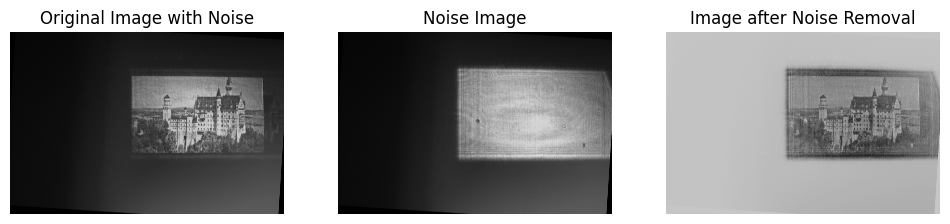

Noise removed and saved to .//Image064_post.png


True

In [79]:
def remove_noise(image_path, noise_image_path, output_path):
    # 이미지를 읽어옵니다 (8-bit grayscale 또는 RGB)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    noise_image = cv2.imread(noise_image_path, cv2.IMREAD_GRAYSCALE)

    # 이미지와 노이즈 이미지가 같은 크기인지 확인
    if image.shape != noise_image.shape:
        raise ValueError("Image and noise image must have the same dimensions.")

    # 노이즈 이미지를 약하게 적용
    noise_image = (noise_image * 1.5)
    # .astype(np.uint8)
    # noise_image = (noise_image **2 )
    # .astype(np.uint8)
    # clean_image = cv2.GaussianBlur(image, (15, 15), 10)
    # noise_image = cv2.GaussianBlur(noise_image, (15, 15), 10)
    # clean_image = cv2.subtract(image, noise_image)
    
    clean_image = (np.max(noise_image) + image-noise_image)
    # clean_image = (image-noise_image)
    clean_image = ((clean_image - np.min(clean_image)) / (np.max(clean_image)-np.min(clean_image)) * 255).astype(np.uint8)

    # Fourier Transform을 사용해 이미지에서 노이즈 이미지 제거
    # clean_image_fft = fft(image) - fft(noise_image)
    # clean_image = ifft(clean_image_fft)


    # 결과 플롯
    plt.figure(figsize=(12, 4))
    plots = [image, noise_image, clean_image]
    titles = ["Original Image with Noise", "Noise Image", "Image after Noise Removal"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plots[i], cmap='gray')
        plt.title(titles[i])
        plt.axis("off")
    plt.show()

    # 결과를 저장
    cv2.imwrite(output_path, clean_image)
    cv2.imwrite(f"{save_path}/gray.png", image)

    # clean_image = rotate_image(clean_image, angle=176.3, keep_size=True)
    # image = rotate_image(image, angle=176.3, keep_size=True)
    # cv2.imwrite(image_path, image)
    print(f"Noise removed and saved to {output_path}")

remove_noise(f"{save_path}/{target_image}.png", f"{save_path}/Image061.png", f"{save_path}/{target_image}_post.png")
# remove_noise(f"{save_path}/성사진.png", f"{save_path}/노이즈 사진.png", f"{save_path}/{target_image}_post.png")

cv2.imwrite(f"{save_path}/black.png", np.ones((2160, 3840)))


torch.Size([3728, 5600, 3])


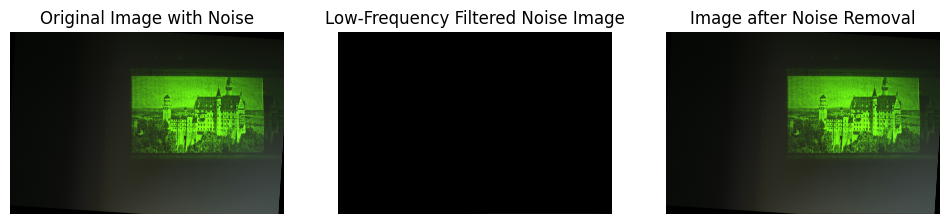

Noise removed and saved to .//Image064_post.png


In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def remove_noise_with_low_freq_filtering(image_path, noise_image_path, output_path, intensity=0.5):
    # 이미지를 읽어옵니다 (8-bit grayscale 또는 RGB)
    image = cv2.imread(image_path)
    noise_image = cv2.imread(noise_image_path)

    # 이미지와 노이즈 이미지가 같은 크기인지 확인
    if image.shape != noise_image.shape:
        raise ValueError("Image and noise image must have the same dimensions.")

    # 노이즈 이미지를 저주파 필터링
    noise_fft = fft(noise_image)
    noise_fft_filtered = apply_low_pass_filter(noise_fft, cutoff=5)  # cutoff를 조절하여 필터 강도 조절
    noise_image_filtered = ifft(noise_fft_filtered)

    # 필터링된 노이즈 이미지를 intensity에 따라 약화시킴
    noise_image_adjusted = (noise_image_filtered * intensity).astype(np.uint8)
    clean_image = cv2.subtract(image, noise_image_adjusted)

    # 결과 이미지 표시
    plt.figure(figsize=(12, 4))
    plots = [image, noise_image_adjusted, clean_image]
    titles = ["Original Image with Noise", "Low-Frequency Filtered Noise Image", "Image after Noise Removal"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plots[i], cmap='gray')
        plt.title(titles[i])
        plt.axis("off")
    plt.show()

    # 결과를 저장
    cv2.imwrite(output_path, clean_image)
    cv2.imwrite(f"{save_path}/noise.png", noise_image_adjusted)
    cv2.imwrite(f"{save_path}/origin.png", image)
    print(f"Noise removed and saved to {output_path}")

# 예시: 함수 호출
remove_noise_with_low_freq_filtering(f"{save_path}/{target_image}.png", f"{save_path}/Image061.png", f"{save_path}/{target_image}_post.png")


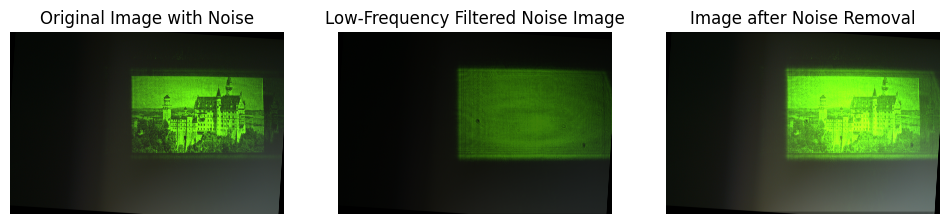

Noise removed and saved to .//Image064_post.png


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# def fft_with_padding(image, target_size):
#     # 입력 이미지를 target_size로 zero-padding 하여 FFT 수행
#     dft = torch.fft.fft2(image)
#     dft_shift = np.fft.fftshift(dft)
#     return dft_shift

# def ifft_with_padding(fshift):
#     # zero-padding을 적용한 주파수 성분에서 역 FFT 수행
#     f_ishift = np.fft.ifftshift(fshift)
#     img_back = np.fft.ifft2(f_ishift)
#     img_back = np.abs(img_back)
#     img_back = np.clip(img_back, 0, 255).astype(np.uint8)
#     return img_back

# def apply_low_pass_filter(fshift, cutoff=5):
#     # fshift의 중심 부분만 남기고 나머지를 0으로 설정하여 저주파 필터링
#     rows, cols = fshift.shape
#     crow, ccol = rows // 2, cols // 2

#     # 전체를 0으로 만들고 중심 부분만 남김
#     mask = np.zeros_like(fshift)
#     mask[crow - cutoff:crow + cutoff, ccol - cutoff:ccol + cutoff] = 1
#     fshift_filtered = fshift * mask
#     return fshift_filtered

# def apply_high_pass_filter(fshift, cutoff=5):
#     # fshift의 중심 부분만 남기고 나머지를 0으로 설정하여 저주파 필터링
#     rows, cols = fshift.shape
#     crow, ccol = rows // 2, cols // 2

#     # 전체를 0으로 만들고 중심 부분만 남김
#     mask = np.ones_like(fshift)
#     mask[crow - cutoff:crow + cutoff, ccol - cutoff:ccol + cutoff] = 0
#     fshift_filtered = fshift * mask
#     return fshift_filtered

def center_crop(image, target_shape):
    # 확대된 이미지에서 중앙 부분을 target_shape로 크롭
    # center_y, center_x = image.shape[0] // 2, image.shape[1] // 2
    crop_y, crop_x = target_shape[0], target_shape[1]
    cropped_image = image[0:crop_y, 0:crop_x]
    return cropped_image

def enlarge_in_frequency_domain(image_path,noise_image_path, output_path, scale_factor=2, intensity=0.5):
    # 이미지를 그레이스케일로 로드
    image = cv2.imread(image_path)
    noise_image = cv2.imread(noise_image_path)
    original_shape = image.shape

    # 원래 크기에서 scale_factor 만큼 확대된 target 크기 설정
    target_size = (int(original_shape[0] * scale_factor), int(original_shape[1] * scale_factor))

    # 주파수 도메인에서 zero-padding을 사용하여 해상도 확장
    noise_fft = fft(noise_image)
    noise_fft_filtered_low = apply_low_pass_filter(noise_fft, cutoff=50)  # cutoff를 조절하여 필터 강도 조절
    noise_fft_filtered_high = apply_high_pass_filter(noise_fft, cutoff=3)  # cutoff를 조절하여 필터 강도 조절

    noise_fft_filtered_low = ifft(noise_fft_filtered_low)
    noise_fft_filtered_high = ifft(noise_fft_filtered_high)
    noise_fft_filtered_low = center_crop(noise_fft_filtered_low, original_shape)
    noise_fft_filtered_high = center_crop(noise_fft_filtered_high, original_shape)
    # noise_fft = fft(noise_image)
    # noise_image_filtered = ifft(noise_fft_filtered)


    # 필터링된 노이즈 이미지를 intensity에 따라 약화시킴
    noise_fft_filtered_low = (noise_fft_filtered_low * intensity).astype(np.uint8)
    noise_fft_filtered_high = (noise_fft_filtered_high * intensity).astype(np.uint8)

    # 원본 이미지에서 필터링된 노이즈 이미지 제거
    clean_image = cv2.subtract(image, noise_fft_filtered_low)
    clean_image = cv2.add(clean_image, noise_fft_filtered_high)

    # 결과 이미지 표시
    plt.figure(figsize=(12, 4))
    plots = [image, noise_fft_filtered_high, clean_image]
    titles = ["Original Image with Noise", "Low-Frequency Filtered Noise Image", "Image after Noise Removal"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plots[i], cmap='gray')
        plt.title(titles[i])
        plt.axis("off")
    
    plt.show()

    # 결과를 저장
    cv2.imwrite(output_path, clean_image)
    cv2.imwrite(f"{save_path}/noise.png", noise_fft_filtered_high)
    cv2.imwrite(f"{save_path}/origin.png", image)
    print(f"Noise removed and saved to {output_path}")


# 예시: 함수 호출
enlarge_in_frequency_domain(f"{save_path}/Image064.png", f"{save_path}/Image061.png", f"{save_path}/Image064_post.png")
